Supervised Anomaly Classification


📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63051
           1       0.71      0.31      0.43       146

    accuracy                           1.00     63197
   macro avg       0.86      0.65      0.71     63197
weighted avg       1.00      1.00      1.00     63197


🧮 Confusion Matrix:
[[63033    18]
 [  101    45]]

🎯 ROC AUC Score: 0.8955721428380548


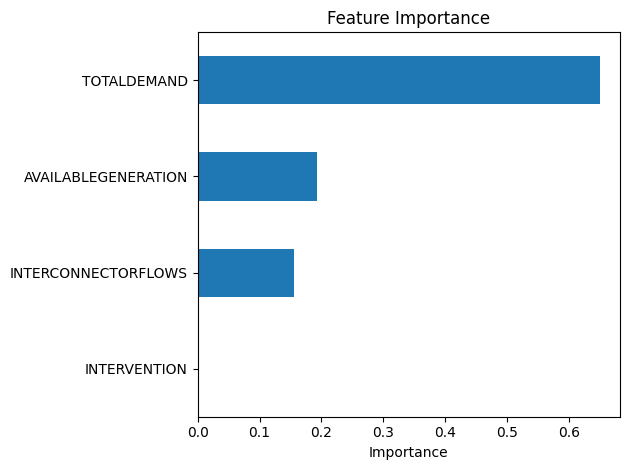

In [2]:
# 📦 Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# 🔹 1. Load and Prepare Data
# ============================
df = pd.read_csv("combined_dispatch_price_demand_2023_2024.csv", parse_dates=["SETTLEMENTDATE"])

# ✅ Drop rows with missing values in key features
features = [
    "TOTALDEMAND",
    "AVAILABLEGENERATION",
    "INTERCONNECTORFLOWS",
    "INTERVENTION"
]
df = df.dropna(subset=features + ["is_anomaly"])

# ✅ Feature matrix and target
X = df[features]
y = df["is_anomaly"].astype(int)

# ============================
# 🔹 2. Train/Test Split
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ============================
# 🔹 3. Train Classifier
# ============================
model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

# ============================
# 🔍 4. Evaluate Performance
# ============================
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n🧮 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n🎯 ROC AUC Score:", roc_auc_score(y_test, y_proba))

# ============================
# 📈 5. Feature Importance
# ============================
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind="barh", title="Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


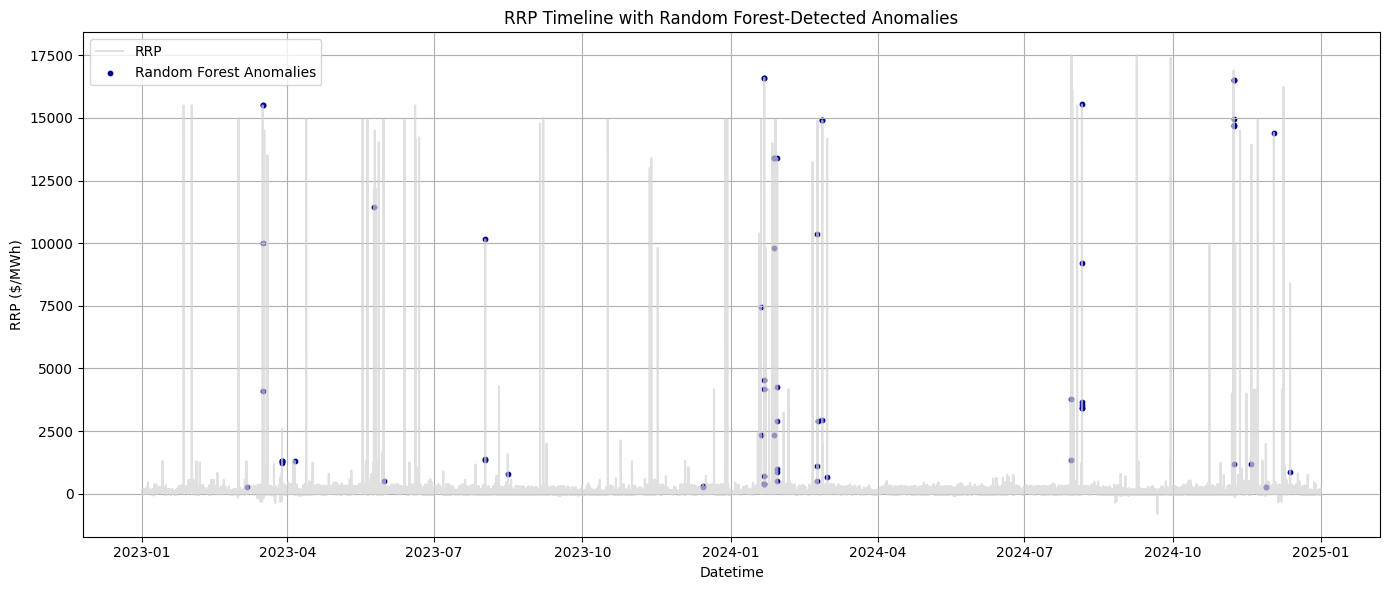

In [3]:
# Plotting Anomalies Detected by Random Forest

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data (make sure this is the same one used for ML evaluation)
df = pd.read_csv("combined_dispatch_price_demand_2023_2024.csv", parse_dates=["SETTLEMENTDATE"])

# Recreate target and features
df["is_anomaly"] = (df["RRP"] > 1000).astype(int)
df["RESERVE_MARGIN"] = df["AVAILABLEGENERATION"] - df["TOTALDEMAND"]
features = ["TOTALDEMAND", "AVAILABLEGENERATION", "INTERCONNECTORFLOWS", "RESERVE_MARGIN"]

# Drop rows with missing values
df_ml = df.dropna(subset=features + ["is_anomaly"]).copy()

# Reload model predictions (if you have them saved, or re-run training block first)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare features and scale
X = df_ml[features]
y = df_ml["is_anomaly"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(
    X_scaled, y, df_ml.index, test_size=0.3, stratify=y, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
df_ml.loc[index_test, "rf_anomaly"] = y_pred

# Plot timeline of RRP with Random Forest anomalies
plt.figure(figsize=(14, 6))
plt.plot(df_ml["SETTLEMENTDATE"], df_ml["RRP"], label="RRP", color="lightgray", alpha=0.7)
plt.scatter(df_ml[df_ml["rf_anomaly"] == 1]["SETTLEMENTDATE"],
            df_ml[df_ml["rf_anomaly"] == 1]["RRP"],
            color="darkblue", s=10, label="Random Forest Anomalies")

plt.title("RRP Timeline with Random Forest-Detected Anomalies")
plt.xlabel("Datetime")
plt.ylabel("RRP ($/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


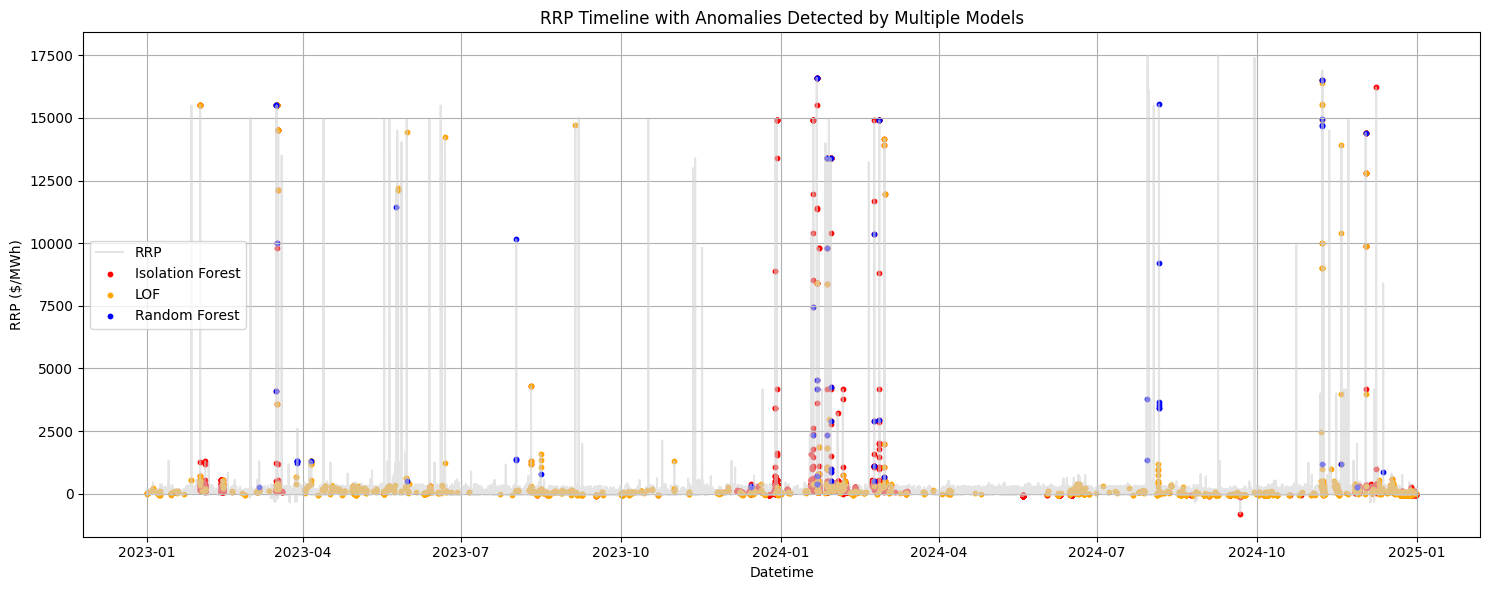

In [4]:
# Plotting Anomalies Detected by Random Forest, Isolation Forest, and LOF

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv("combined_dispatch_price_demand_2023_2024.csv", parse_dates=["SETTLEMENTDATE"])
df["is_anomaly"] = (df["RRP"] > 1000).astype(int)
df["RESERVE_MARGIN"] = df["AVAILABLEGENERATION"] - df["TOTALDEMAND"]

features = ["TOTALDEMAND", "AVAILABLEGENERATION", "INTERCONNECTORFLOWS", "RESERVE_MARGIN"]
df_ml = df.dropna(subset=features + ["is_anomaly"]).copy()

# Scale features
X = df_ml[features]
y = df_ml["is_anomaly"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Unsupervised: Isolation Forest ---
iso_model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df_ml["iso_anomaly"] = iso_model.fit_predict(X_scaled)
df_ml["iso_anomaly"] = df_ml["iso_anomaly"].map({1: 0, -1: 1})

# --- Unsupervised: LOF ---
lof = LocalOutlierFactor(n_neighbors=50, contamination=0.01)
df_ml["lof_anomaly"] = lof.fit_predict(X_scaled)
df_ml["lof_anomaly"] = df_ml["lof_anomaly"].map({1: 0, -1: 1})

# --- Supervised: Random Forest ---
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(
    X_scaled, y, df_ml.index, test_size=0.3, stratify=y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
df_ml.loc[index_test, "rf_anomaly"] = y_pred

# --- Plot timeline ---
plt.figure(figsize=(15, 6))
plt.plot(df_ml["SETTLEMENTDATE"], df_ml["RRP"], label="RRP", color="lightgray", alpha=0.6)

plt.scatter(df_ml[df_ml["iso_anomaly"] == 1]["SETTLEMENTDATE"],
            df_ml[df_ml["iso_anomaly"] == 1]["RRP"],
            color="red", s=10, label="Isolation Forest")

plt.scatter(df_ml[df_ml["lof_anomaly"] == 1]["SETTLEMENTDATE"],
            df_ml[df_ml["lof_anomaly"] == 1]["RRP"],
            color="orange", s=10, label="LOF")

plt.scatter(df_ml[df_ml["rf_anomaly"] == 1]["SETTLEMENTDATE"],
            df_ml[df_ml["rf_anomaly"] == 1]["RRP"],
            color="blue", s=10, label="Random Forest")

plt.title("RRP Timeline with Anomalies Detected by Multiple Models")
plt.xlabel("Datetime")
plt.ylabel("RRP ($/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

